<a href="https://colab.research.google.com/github/zhengweiyu/Awesome-WAF/blob/master/TwoMeanStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
# 导入必要的库
import yfinance as yf
import pandas as pd
import backtrader as bt
import numpy as np
from datetime import datetime  # Add this import
import matplotlib.pyplot as plt


In [ ]:
class TwoMeanStrategy(bt.Strategy):
    params = (
        ("long_period", 20),
        ("short_period", 5),
        ("range_threshold", 0.8),
        ("exit_threshold", 2.0),
        ("position_percent", 80),
        ("slippage_perc", 0.5),
        ("days_between_trades", 2),
        ("noise_filter_percent", 0),  # Add a noise filter percentage
        ("volatility_threshold", 0.01),  # 波动率阈值
        ("lookback_days", 20),  # 半年内交易日数量
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        self.sma = bt.indicators.SimpleMovingAverage(self.data_close, period=self.params.long_period)
        self.ema = bt.indicators.ExponentialMovingAverage(self.data_close, period=self.params.short_period)
        self.buy_signal = bt.indicators.CrossOver(self.ema, self.sma)
        self.sell_signal = bt.indicators.CrossDown(self.ema, self.sma)
        self.last_trade_date = None

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def should_exit(self):
        range_condition = abs(self.data_close[0] - self.sma[0]) < self.params.range_threshold
        downturn_condition = (self.data_close[0] / self.data_close[-1]) < (1.0 - self.params.exit_threshold / 100)
        return self.sell_signal > 0 and (range_condition or downturn_condition)

    def is_horizontal_consolidation(self):
        # 计算历史波动率
        returns = np.diff(np.log(np.array(self.data_close.get(ago=-1, size=self.params.lookback_days))))
        volatility = np.std(returns)
        # 判断波动率是否高于阈值
        return volatility > self.params.volatility_threshold

    def noise_filter(self):
        # Add a noise filter condition - execute trade only when the percentage change exceeds the noise filter
        return abs((self.data_close[0] - self.data_close[-1]) / self.data_close[-1]) > self.params.noise_filter_percent

    def next(self):
        if not self.position and self.is_horizontal_consolidation():
            if self.buy_signal > 0 and self.noise_filter():
                if self.last_trade_date is not None and (self.data.datetime.date(0) - self.last_trade_date).days < self.params.days_between_trades:
                    return

                amount_to_invest = (self.params.position_percent / 100) * self.broker.getvalue()
                size = int(amount_to_invest / self.data_close[0])

                slippage = self.data_close[0] * self.params.slippage_perc / 100
                buy_price = self.data_close[0] + slippage

                self.log('Buy signal triggered, %.2f' % self.data_close[0])
                self.log_trade_info('Buy', size, buy_price)

                self.buy(size=size, price=buy_price)
                self.last_trade_date = self.data.datetime.date(0)

        elif self.position and self.should_exit():
            self.log('Exit signal triggered, %.2f' % self.data_close[0])
            self.log_trade_info('Sell', self.position.size, self.data_close[0])
            self.close()

    def log_trade_info(self, direction, size, price):
        self.log('Trade direction: %s, Trade quantity: %d, Trade price: %.2f' % (direction, size, price))

In [ ]:
def load_and_prepare_data(symbol, start_date, end_date):
    # Download data from Yahoo Finance
    data = yf.download(symbol, start=start_date, end=end_date)

    # Convert the Series to a DataFrame
    data = pd.DataFrame(data)

    # Handle NaN values in the data
    data.dropna(inplace=True)

    # Add data feed
    feed = bt.feeds.PandasData(dataname=data)

    return feed



In [ ]:
def plot_results(cerebro):
    # 设置图表大小
    plt.rcParams['figure.figsize'] = [12, 8]

    # 将横轴加上时间
    cerebro.plot(iplot=False, fmt_x_data=True)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())



In [ ]:
def main():
    # 初始化数据
    symbol = "QQQ"
    start_date = "2019-01-01"
    end_date = "2024-12-31"
    feed = load_and_prepare_data(symbol, start_date, end_date)

    # 创建Cerebro实例
    cerebro = bt.Cerebro()

    # 添加策略
    cerebro.addstrategy(TwoMeanStrategy)

    # 添加数据到Cerebro
    cerebro.adddata(feed, name='ETF')

    # 设置初始资金
    cerebro.broker.setcash(10000.0)

    # 打印初始条件
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # 运行回测
    cerebro.run()

    # 绘制结果
    plot_results(cerebro)


[*********************100%%**********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
2019-06-10, Buy signal triggered, 183.15
2019-06-10, Trade direction: Buy, Trade quantity: 43, Trade price: 184.07
2019-09-25, Exit signal triggered, 190.08
2019-09-25, Trade direction: Sell, Trade quantity: 43, Trade price: 190.08
2019-10-14, Buy signal triggered, 191.09
2019-10-14, Trade direction: Buy, Trade quantity: 42, Trade price: 192.05
2020-02-25, Exit signal triggered, 215.37
2020-02-25, Trade direction: Sell, Trade quantity: 42, Trade price: 215.37
2020-04-02, Buy signal triggered, 186.01
2020-04-02, Trade direction: Buy, Trade quantity: 48, Trade price: 186.94
2022-01-05, Exit signal triggered, 384.29
2022-01-05, Trade direction: Sell, Trade quantity: 48, Trade price: 384.29
2022-02-10, Buy signal triggered, 358.43
2022-02-10, Trade direction: Buy, Trade quantity: 46, Trade price: 360.22
2022-02-11, Exit signal triggered, 347.06
2022-02-11, Trade direction: Sell, Trade qu

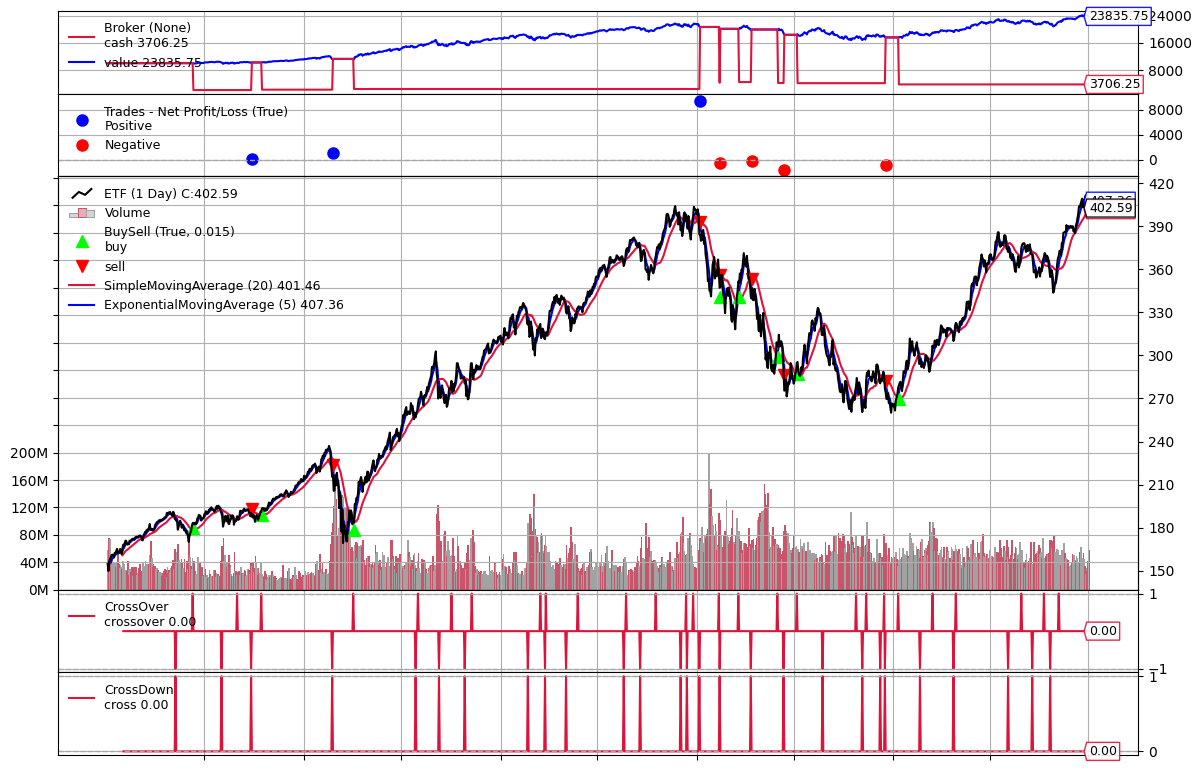

Final Portfolio Value: 23835.75


In [ ]:

if __name__ == '__main__':
  main()